# Nordic Optical Telescope images of Ou 5

Images from ALFOSC instrument downloaded from IAC with help of Sergio Armas Pérez <sap@not.iac.es> 2025-07-05

## Imports

In [1]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mes_longslit import regrid_images

/Users/will/Dropbox/teresa-pn-ou5/.venv/lib/python3.11/site-packages/FITS_tools/__init__.py:33: UserWarning: module 'astropy.config.configuration' has no attribute 'update_default_config', which has been deprecated in astropy 6.1.1.
  warn(wmsg)


## Load headers from all the individual images

In [2]:
datadir = Path.cwd().parent / "data/nordic-images"
_files = sorted(datadir.glob("AL*.fits"))
primary_headers = {
    _.stem: fits.open(_)[0].header
    for _ in _files
}
# list(primary_headers.keys())

## Make table of relevant data from the headers

We want the filters and the exposure time at least

In [3]:
tab = Table(
    [
        {"Name": _name, 
         **{_key: primary_headers[_name][_key] 
            for _key in ["ALFLTNM", "FBFLTNM", "EXPTIME", "DATE-OBS"]}
        }
        for _name in primary_headers
    ]
)
tab

Name,ALFLTNM,FBFLTNM,EXPTIME,DATE-OBS
str10,str13,str12,float64,str23
ALwj290115,i_int 797_157,Open,120.0,2013-10-29T19:27:35.209
ALwj290116,Open,Open,60.0,2013-10-29T19:30:31.195
ALwj290117,i_int 797_157,Open,60.0,2013-10-29T19:33:02.715
ALwj290240,i_int 797_157,Open,120.0,2013-10-30T02:31:07.698
ALwj290241,i_int 797_157,Open,60.0,2013-10-30T02:33:49.828
ALwk070080,Open,[OIII] 501_3,900.0,2013-11-07T21:41:34.675
ALwk070081,Open,[OIII] 501_3,900.0,2013-11-07T21:57:09.752
ALwk070097,Open,Halp 658_18,900.0,2013-11-07T23:21:52.391
ALwk070098,Open,Halp 658_18,900.0,2013-11-07T23:37:27.275


So the continuum images have the ALFLTNM and the line images have the FBFLTNM

## Select the frames for each emission line

In [4]:
emline_frame_names = {
    "ha": ["ALwk070097", "ALwk070098"],
    "oiii": ["ALwk070080", "ALwk070081"],
    "heii": ["ALze250092", "ALze250093", "ALze250094"], 
}

In [5]:
hdus = {
    _line: [
        fits.open(datadir / (_name + ".fits"))[1]
        for _name in _names
    ] for _line, _names in emline_frame_names.items()
}

In [6]:
hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x169748a10>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x169754410>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x169763410>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x169786550>]}

## Reproject all frames to a common grid

### Look at an example full frame

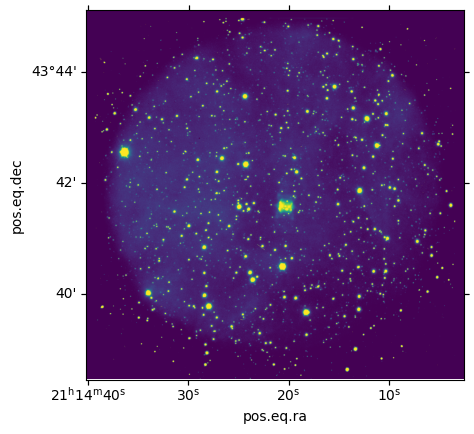

In [7]:
hdu = hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=11000, vmax=13000)

Here we see the PN surrounded by diffuse emission from the foreground H II region Sh 2-119

In [8]:
bias = np.median(hdu.data[:100, :100])
bias

10016.0

### Reference coordinate for the PN from Simbad. 

Hopefully, this is the position of the central star

In [9]:
c0 = SkyCoord.from_name("PN Ou 5")
c0.ra.to_string(u.hour), c0.dec.to_string(u.deg)

('21h14m20.03539402s', '43d41m36.04832234s')

### Zoom in on the PN

In [10]:
w.world_to_pixel(c0)

(array(1147.30186152), array(991.37403499))

Pixel size

In [11]:
3600 * w.wcs.cd[1, 1]

0.1903094997031854

So that is about 0.2 arcsec. Make a window of 80 arcsec square, as I did previously in 01-01-median-image notebook

In [12]:
j0, i0 = w.world_to_array_index(c0)

In [13]:
zoom_size = 40
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(947, 1347, None), slice(791, 1191, None))

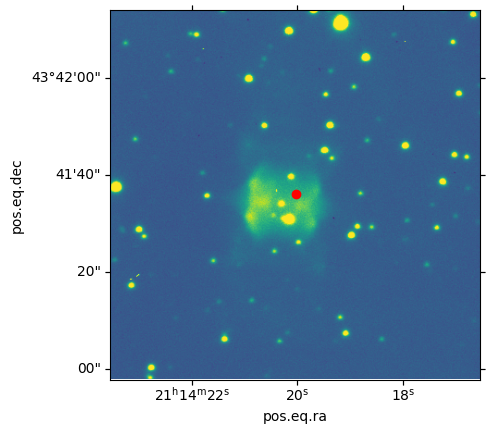

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r")

CSPN is not centered. I have measured its pixel position in DS9

In [15]:
istar, jstar = 1133.454, 981.86892
istar - i0, jstar - j0

(-13.54600000000005, -9.131079999999997)

### Fix the alignment

So one way of fixing it is to set crpix to [istar, jstar] and crval to c0

In [16]:
wfix = w.copy()
wfix.wcs.crpix = istar, jstar
wfix.wcs.crval = c0.ra.deg, c0.dec.deg

Recalculate the zoom window around the corrected position

In [17]:
j0, i0 = wfix.world_to_array_index(c0)
zoom_size = 35
zoom_xslice = slice(i0 - 5 * zoom_size, i0 + 5 * zoom_size)
zoom_yslice = slice(j0 - 5 * zoom_size, j0 + 5 * zoom_size)
zoom_xslice, zoom_yslice

(slice(957, 1307, None), slice(806, 1156, None))

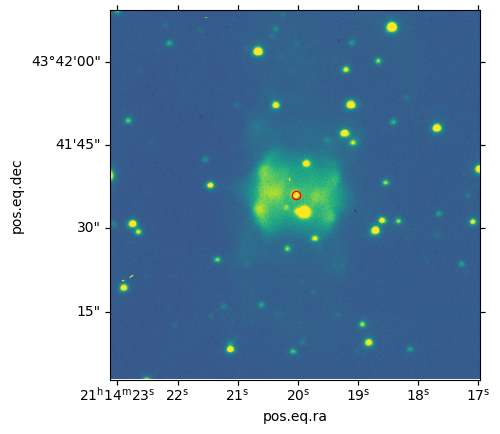

In [18]:
fig, ax = plt.subplots(subplot_kw=dict(projection=wfix))
ax.imshow(hdu.data - bias, origin="lower", vmin=0, vmax=4000)
ax.set_xlim(zoom_xslice.start, zoom_xslice.stop)
ax.set_ylim(zoom_yslice.start, zoom_yslice.stop)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Do the reprojection of all the images

We will use my `mes_longslit.regrid_images()` function, but first we need to measure the pixel position of the central star on all the images. 

I do this by hand in DS9 and record the results in the following dict:

In [19]:
crpix_CSPN = {
    "ALwk070097": (1133.454, 981.86892), 
    "ALwk070098": (1054.2045, 982.06465),
    "ALwk070080": (1096.16, 980.96),
    "ALwk070081": (1017.3492, 981.18918),
    "ALze250092": (1062.6922, 1017.6262),
    "ALze250093": (1061.9223, 1017.9001),
    "ALze250094": (1061.5267, 1018.005),
}

Fixup all the alignments, writing back into the HDU headers. And subtract bias while we are at it

In [22]:
for _line in "ha", "oiii", "heii":
    for _hdu, _name in zip(hdus[_line], emline_frame_names[_line]):
        w = WCS(_hdu.header)
        w.wcs.crpix = crpix_CSPN[_name]
        w.wcs.crval = c0.ra.deg, c0.dec.deg
        _hdu.header.update(w.to_header())
        _hdu.data = _hdu.data.astype("float")
        bias = np.median(_hdu.data[:100, :100])
        _hdu.data -= bias

In [36]:
fits.HDUList([hdu])

In [23]:
new_hdus = {
    _line: [
        regrid_images(
            fits.HDUList([_hdu]),
            center=c0, 
            pixscale=0.2 * u.arcsec,
            shape=(400, 400),
        )[0]
        for _hdu in hdus[_line]
    ]
    for _line in ["ha", "oiii", "heii"]
}

In [24]:
new_hdus

{'ha': [<astropy.io.fits.hdu.image.ImageHDU at 0x31924c610>,
 'oiii': [<astropy.io.fits.hdu.image.ImageHDU at 0x1697624d0>,
 'heii': [<astropy.io.fits.hdu.image.ImageHDU at 0x31f103390>,
  <astropy.io.fits.hdu.image.ImageHDU at 0x1759cd550>]}

### Check that they came out ok

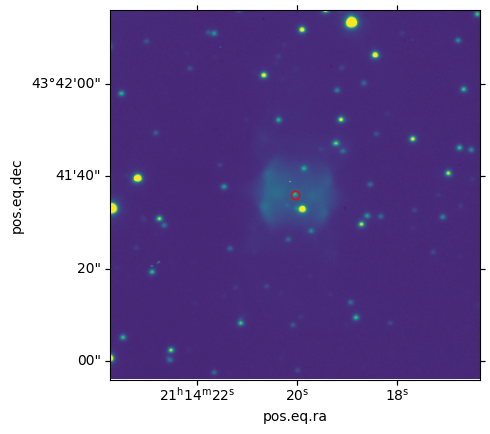

In [34]:
hdu = new_hdus["ha"][0]
w = WCS(hdu.header)
fig, ax = plt.subplots(subplot_kw=dict(projection=w))
ax.imshow(hdu.data, origin="lower", vmin=0, vmax=10000)
ax.plot_coord(c0, "o", color="r", fillstyle="none")

### Save the regridded aligned images

In [36]:
for _line in "ha", "oiii", "heii":
    for _i, _hdu in enumerate(new_hdus[_line]):
        _hdu.writeto(
            datadir / f"nordic-ou5-{_line}-{_i:02d}-regrid.fits",
            overwrite=True,
        )

## Co-add all exposures of each line